In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
bert_version = 'bert-large-cased'
tokenizer = BertTokenizer.from_pretrained(bert_version)
model = BertModel.from_pretrained(bert_version)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

In [ ]:
model = model.eval()
model = model.to(device)

In [ ]:
texts  = [
    "function selectActivities(start, finish, N):",
    "    activities = []",
    "    for i from 0 to N-1:",
    "        activities.append((start[i], finish[i], i))",
    "    sort(activities, by finish time)",
    "    selectedActivities = []",
    "    selectedActivities.append(activities[0])",
    "    lastFinishTime = activities[0].finish",
    "    for i from 1 to N-1:",
    "        if activities[i].start >= lastFinishTime:",
    "            selectedActivities.append(activities[i])",
    "            lastFinishTime = activities[i].finish",
    '    print "Number of activities selected:", length(selectedActivities)',
    '    print "Selected activities:"',
    "    for each activity in selectedActivities:",
    '        print activity.index'
]

In [ ]:
encodings = tokenizer(texts, padding=True, return_tensors='pt')
encodings = encodings.to(device)

The BERT tokenizer returns three values:


*   input_ids. The list/tensor of token ids for each sentence. The id 101 represents the class token [CLS], 102 represents the separator token [SEP], and 0 represents the padding token [PAD]
*   attention_mask. This list/tensor represents which ids to use when generating the tokens (e.g. ignores the [PAD] tokens).


*   token_type_ids. This list/tensor represents which tokens correspond to the first and second sentence (used for next sentence prediction).






In [ ]:
encodings.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
encodings['input_ids']

tensor([[  101,  3053,  8247,  1592,  5822, 11083,  4233,   113,  1838,   117,
          3146,   117,   151,   114,   131,   102,     0,     0,     0,     0,
             0],
        [  101,  2619,   134,   164,   166,   102,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  1111,   178,  1121,   121,  1106,   151,   118,   122,   131,
           102,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  2619,   119, 12647,  6696,   113,   113,  1838,   164,   178,
           166,   117,  3146,   164,   178,   166,   117,   178,   114,   114,
           102],
        [  101,  3271,   113,  2619,   117,  1118,  3146,  1159,   114,   102,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0],
        [  101,  2700,  1592,  5822, 11083,  4233,   134,   164,   166,   102,
             0,     0,     0,     0,     0,   

In [ ]:
encodings['token_type_ids']

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
encodings['attention_mask']

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:

for tokens in encodings['input_ids']:
    print(tokenizer.convert_ids_to_tokens(tokens))

['[CLS]', 'function', 'select', '##A', '##ct', '##iv', '##ities', '(', 'start', ',', 'finish', ',', 'N', ')', ':', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'activities', '=', '[', ']', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'for', 'i', 'from', '0', 'to', 'N', '-', '1', ':', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'activities', '.', 'app', '##end', '(', '(', 'start', '[', 'i', ']', ',', 'finish', '[', 'i', ']', ',', 'i', ')', ')', '[SEP]']
['[CLS]', 'sort', '(', 'activities', ',', 'by', 'finish', 'time', ')', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']
['[CLS]', 'selected', '##A', '##ct', '##iv', '##ities', '=', '[', ']', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

In [ ]:
with torch.no_grad():
    embeds = model(**encodings)

In [ ]:
embeds = embeds[0]

In [ ]:
embeds

tensor([[[-1.2134e-01, -3.8244e-01, -2.0381e-01,  ..., -3.0143e-01,
          -3.9338e-01,  4.3679e-01],
         [-2.5000e-01, -1.0451e+00, -1.3135e-01,  ..., -3.5677e-01,
           2.5582e-01, -2.4681e-01],
         [-8.8978e-01,  4.4729e-01, -1.6484e-01,  ...,  1.7245e-01,
          -6.8230e-01,  4.3587e-01],
         ...,
         [-5.1861e-01,  1.3828e-01, -1.2522e-01,  ..., -6.6787e-02,
           1.6650e-01, -2.5589e-01],
         [-6.8677e-01,  7.3987e-01,  4.5606e-02,  ...,  6.2882e-01,
          -9.0583e-02,  3.9853e-01],
         [-6.0688e-01,  4.0998e-01,  1.2229e+00,  ...,  8.7534e-03,
          -7.8918e-01,  7.4234e-01]],

        [[-5.8851e-01, -5.2439e-01,  1.0169e+00,  ..., -7.3781e-01,
          -6.2376e-01,  2.3964e-01],
         [-4.7607e-01, -7.5089e-01, -2.1099e-01,  ..., -5.4948e-01,
           1.7220e-01, -1.0637e-03],
         [-4.1408e-01,  5.5599e-02, -6.5525e-02,  ...,  3.7667e-01,
          -5.4746e-01,  6.0453e-01],
         ...,
         [-7.2779e-01,  5

In [ ]:
def visualize(distances, figsize=(10, 5), titles=None):
    # get the number of columns
    ncols = len(distances)
    # create the subplot placeholders
    fig, ax = plt.subplots(ncols=ncols, figsize=figsize)

    for i in range(ncols):

        # get the axis in which we will draw the matrix
        axes = ax[i] if ncols > 1 else ax

        # get the i-th distance
        distance = distances[i]

        # create the heatmap
        axes.imshow(distance)

        # show the ticks
        axes.set_xticks(np.arange(distance.shape[0]))
        axes.set_yticks(np.arange(distance.shape[1]))

        # set the tick labels
        axes.set_xticklabels(np.arange(distance.shape[0]))
        axes.set_yticklabels(np.arange(distance.shape[1]))

        # set the values in the heatmap
        for j in range(distance.shape[0]):
            for k in range(distance.shape[1]):
                text = axes.text(k, j, str(round(distance[j, k], 3)),
                               ha="center", va="center", color="w")

        # set the title of the subplot
        title = titles[i] if titles and len(titles) > i else "Text Distance"
        axes.set_title(title, fontsize="x-large")

    fig.tight_layout()
    plt.show()

In [ ]:
CLSs = embeds[:, 0, :]

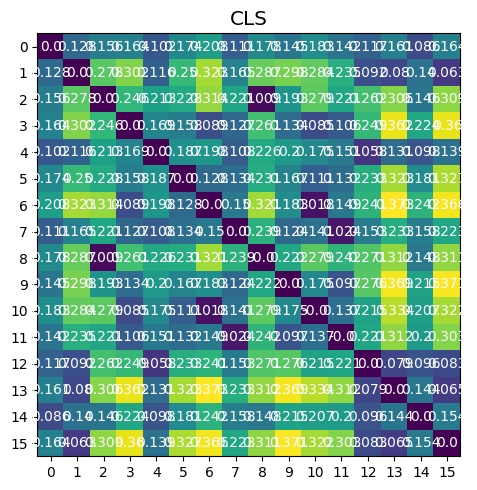

In [ ]:
normalized = F.normalize(CLSs, p=2, dim=1)
# calculate the cosine similarity
cls_dist = normalized.matmul(normalized.T)
cls_dist = cls_dist.new_ones(cls_dist.shape) - cls_dist
cls_dist = cls_dist.cpu().numpy()
visualize([cls_dist], titles=["CLS"])

In [ ]:
MEANS = embeds.mean(dim=1)

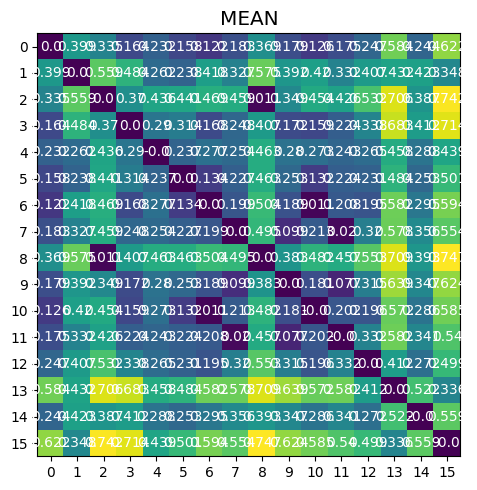

In [ ]:
# normalize the MEANS token embeddings
normalized = F.normalize(MEANS, p=2, dim=1)
# calculate the cosine similarity
mean_dist = normalized.matmul(normalized.T)
mean_dist = mean_dist.new_ones(mean_dist.shape) - mean_dist
mean_dist = mean_dist.cpu().numpy()
visualize([mean_dist], titles=["MEAN"])

In [ ]:
MAXS, _ = embeds.max(dim=1)

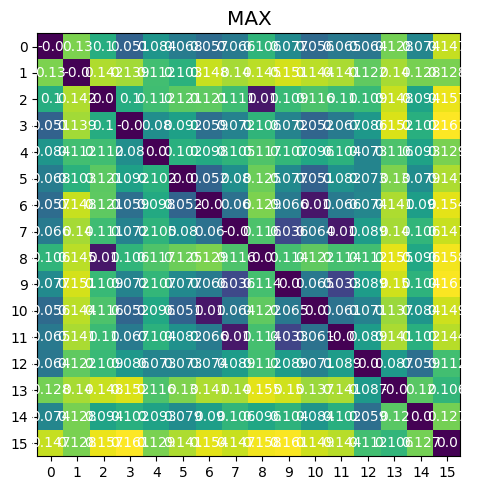

In [ ]:
# normalize the MEANS token embeddings
normalized = F.normalize(MAXS, p=2, dim=1)
# calculate the cosine similarity
max_dist = normalized.matmul(normalized.T)
max_dist = max_dist.new_ones(max_dist.shape) - max_dist
max_dist = max_dist.cpu().numpy()
visualize([max_dist], titles=["MAX"])

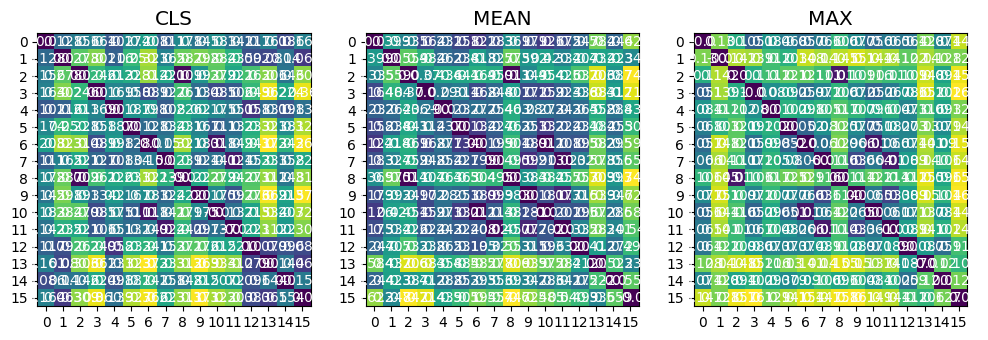

In [ ]:
dist = [cls_dist, mean_dist, max_dist]
titles = ["CLS", "MEAN", "MAX"]
visualize(dist, titles=titles)

In [ ]:
n_clusters = 5  # Define the number of clusters
kmeans_cls = KMeans(n_clusters=n_clusters).fit(cls_dist)
kmeans_mean = KMeans(n_clusters=n_clusters).fit(mean_dist)
kmeans_max = KMeans(n_clusters=n_clusters).fit(max_dist)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
print("CLS Clusters:", kmeans_cls.labels_)
print("MEAN Clusters:", kmeans_mean.labels_)
print("MAX Clusters:", kmeans_max.labels_)

CLS Clusters: [3 0 2 4 3 1 4 1 2 1 4 1 3 0 3 0]
MEAN Clusters: [1 0 2 1 4 4 1 1 2 1 1 1 4 3 4 3]
MAX Clusters: [1 0 2 1 3 1 1 4 2 4 1 4 3 0 3 0]


In [ ]:
def visualize_clusters(embeddings, labels, title):
    plt.figure(figsize=(10, 5))
    unique_labels = np.unique(labels)
    for label in unique_labels:
        idx = labels == label
        plt.scatter(embeddings[idx, 0], embeddings[idx, 1], label=f'Cluster {label}')
    plt.title(title)
    plt.legend()
    plt.show()

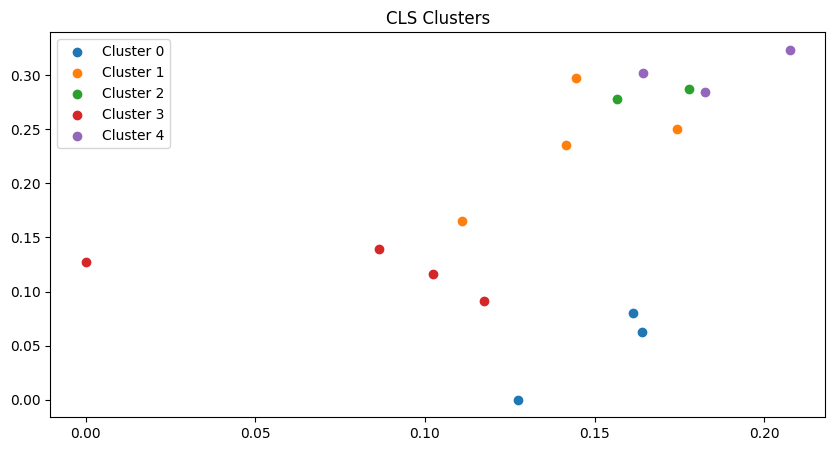

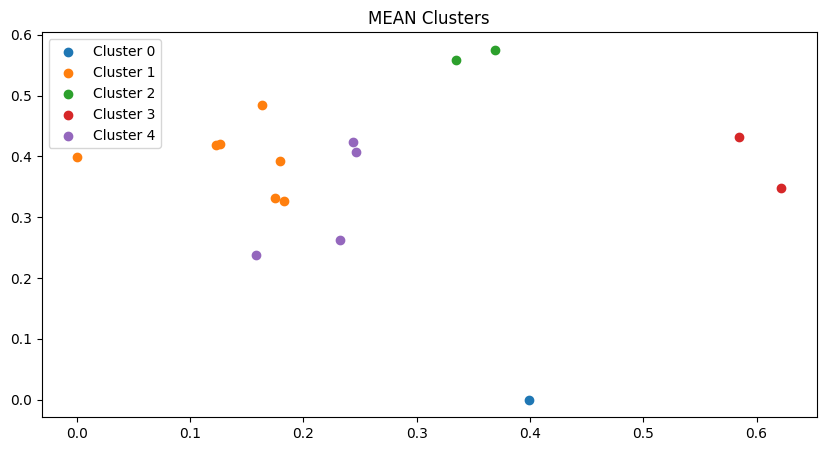

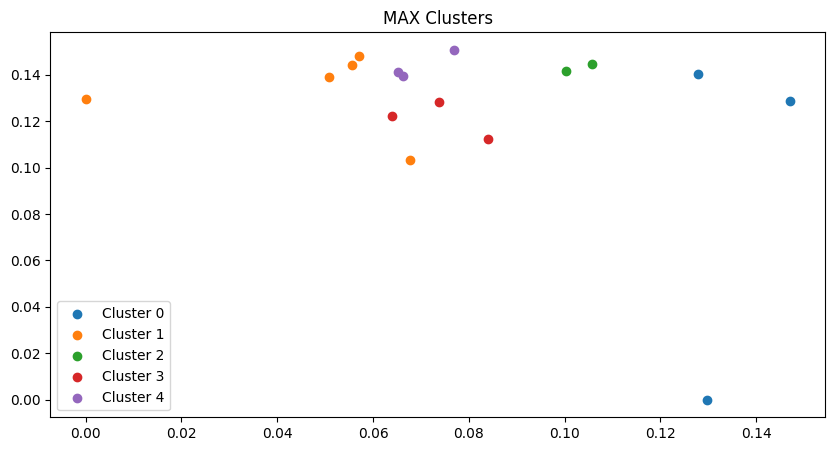

In [ ]:
visualize_clusters(cls_dist, kmeans_cls.labels_, 'CLS Clusters')
visualize_clusters(mean_dist, kmeans_mean.labels_, 'MEAN Clusters')
visualize_clusters(max_dist, kmeans_max.labels_, 'MAX Clusters')

In [ ]:
def print_clusters(texts, labels, title):
    clusters = {}
    for i, label in enumerate(labels):
        if label not in clusters:
            clusters[label] = []
        clusters[label].append(texts[i])

    print(f"\n{title} Clusters:")
    for label, sentences in clusters.items():
        print(f"Cluster {label}:")
        for sentence in sentences:
            print(f"  {sentence}")

# Print sentences in clusters for CLS, MEAN, and MAX embeddings
print_clusters(texts, kmeans_cls.labels_, 'CLS')
print_clusters(texts, kmeans_mean.labels_, 'MEAN')
print_clusters(texts, kmeans_max.labels_, 'MAX')


CLS Clusters:
Cluster 3:
  function selectActivities(start, finish, N):
      sort(activities, by finish time)
      print "Number of activities selected:", length(selectedActivities)
      for each activity in selectedActivities:
Cluster 0:
      activities = []
      print "Selected activities:"
          print activity.index
Cluster 2:
      for i from 0 to N-1:
      for i from 1 to N-1:
Cluster 4:
          activities.append((start[i], finish[i], i))
      selectedActivities.append(activities[0])
              selectedActivities.append(activities[i])
Cluster 1:
      selectedActivities = []
      lastFinishTime = activities[0].finish
          if activities[i].start >= lastFinishTime:
              lastFinishTime = activities[i].finish

MEAN Clusters:
Cluster 1:
  function selectActivities(start, finish, N):
          activities.append((start[i], finish[i], i))
      selectedActivities.append(activities[0])
      lastFinishTime = activities[0].finish
          if activities[i].st

In [ ]:
silhouette_cls = silhouette_score(cls_dist, kmeans_cls.labels_)
silhouette_mean = silhouette_score(mean_dist, kmeans_mean.labels_)
silhouette_max = silhouette_score(max_dist, kmeans_max.labels_)

In [ ]:
print(f"Silhouette Score for CLS: {silhouette_cls}")
print(f"Silhouette Score for MEAN: {silhouette_mean}")
print(f"Silhouette Score for MAX: {silhouette_max}")

Silhouette Score for CLS: 0.430225133895874
Silhouette Score for MEAN: 0.36803698539733887
Silhouette Score for MAX: 0.39226359128952026
